# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activations, optimizers)
### LECTURE: Activation functions comparison
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1

C:\Users\litwi\AppData\Local\Temp\ipykernel_25948\152022097.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
C:\Users\litwi\AppData\Local\Temp\ipykernel_25948\152022097.py:10: SettingWithCopyWar

# Re-organize the data: train/test in DataLoaders

In [3]:
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None]

In [4]:
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Now for the DL part

In [10]:
class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    self.input = nn.Linear(11,16)
    
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    self.output = nn.Linear(32,1)

    self.actfun = actfun
  
  def forward(self,x):
    actfun = getattr(torch.nn,self.actfun)
    x = actfun()( self.input(x) )
    x = actfun()( self.fc1(x) )
    x = actfun()( self.fc2(x) )
    return self.output(x)

# Train the model

In [6]:
numepochs = 1000

def trainTheModel():
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  for epochi in range(numepochs):

    winenet.train()

    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      yHat = winenet(X)
      loss = lossfun(yHat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
        
    trainAcc.append( np.mean(batchAcc) )
    losses[epochi] = np.mean(batchLoss)

    winenet.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  return trainAcc,testAcc,losses

In [12]:
activation_funs = [ 'ReLU', 'ReLU6', 'LeakyReLU' ]

trainByAct = np.zeros((numepochs,len(activation_funs)))
testByAct  = np.zeros((numepochs,len(activation_funs)))

for ai,actfun in enumerate(activation_funs):
    
  winenet = ANNwine(actfun)
  trainByAct[:,ai],testByAct[:,ai],losses = trainTheModel()


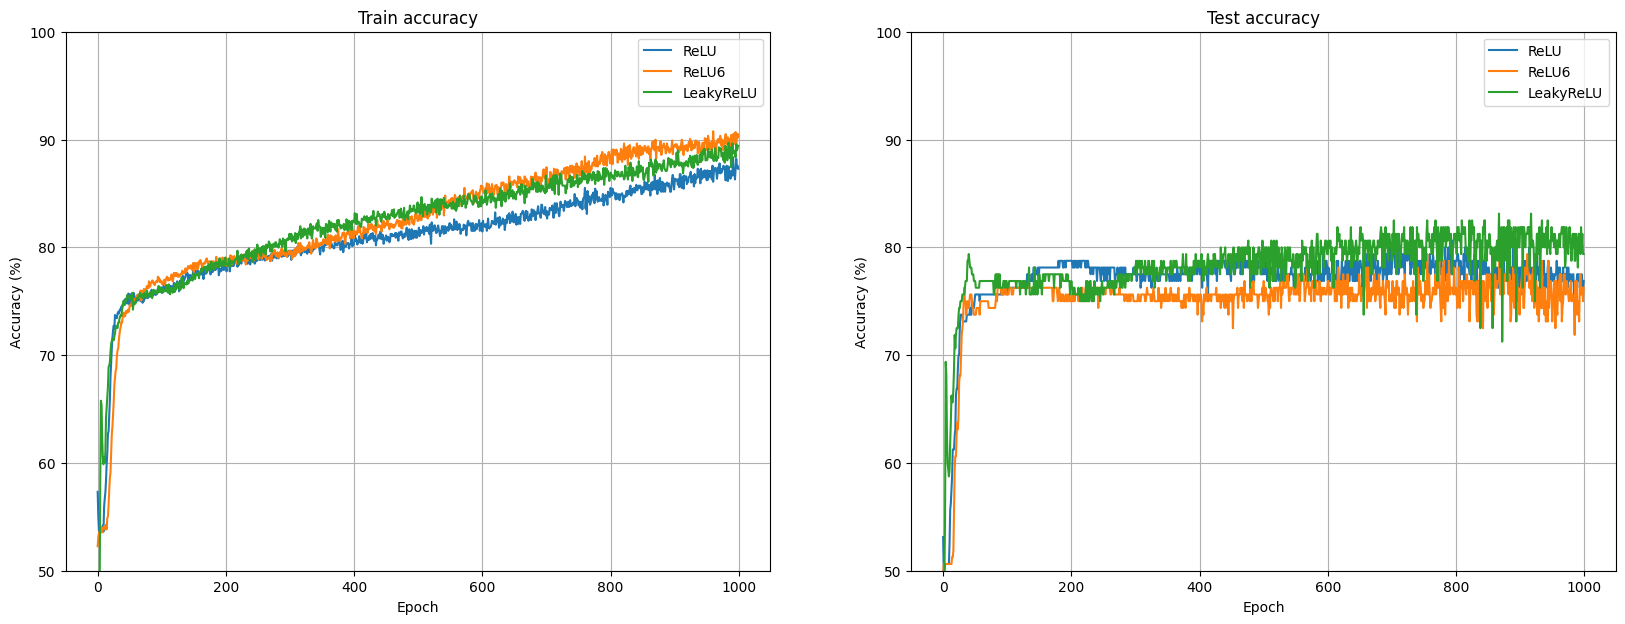

In [13]:
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

for i in range(2):
  ax[i].legend(activation_funs)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()